##### Reading the datasets and preprocessing them

In [1]:
# Imports required to load the datasets from S3 Bucket
import os
import boto3
from boto3 import client

# Additional imports required for the homework tasks
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing

bucketname = "cmu-dshs-diabetes-data"
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(bucketname)
for my_bucket_object in my_bucket.objects.all():
    print(my_bucket_object)

# Using the client system in the boto3 
conn = client('s3')  
for key in conn.list_objects(Bucket=bucketname)['Contents']:
    print(key['Key'])

s3.ObjectSummary(bucket_name='cmu-dshs-diabetes-data', key='Balance - Tablas (Parte 1 ) pacientes.csv')
s3.ObjectSummary(bucket_name='cmu-dshs-diabetes-data', key='Balance - Tablas (Parte 1 ).xlsx')
s3.ObjectSummary(bucket_name='cmu-dshs-diabetes-data', key='Balance - Tablas (Parte 2 ).xlsx')
s3.ObjectSummary(bucket_name='cmu-dshs-diabetes-data', key='Balance - Tablas (Parte 3 ).xlsx')
s3.ObjectSummary(bucket_name='cmu-dshs-diabetes-data', key='DataDictionary version 2.xlsx')
s3.ObjectSummary(bucket_name='cmu-dshs-diabetes-data', key='I Datos CMU (BAL).xlsx')
s3.ObjectSummary(bucket_name='cmu-dshs-diabetes-data', key='II Datos CMU (BAL).xlsx')
s3.ObjectSummary(bucket_name='cmu-dshs-diabetes-data', key='III Datos CMU (ENC).xlsx')
s3.ObjectSummary(bucket_name='cmu-dshs-diabetes-data', key='IV Datos CMU (BAL).xlsx')
s3.ObjectSummary(bucket_name='cmu-dshs-diabetes-data', key='notasevolucionpsic.csv')
s3.ObjectSummary(bucket_name='cmu-dshs-diabetes-data', key='psicologiasesion1.csv')
Balanc

In [2]:
#bucketname = "046355044787-edu-sagemaker-instructor-us-east-1-course"
#s3 = boto3.resource('s3')
#my_bucket = s3.Bucket(bucketname)
#for my_bucket_object in my_bucket.objects.all():
#    print(my_bucket_object)

In [3]:
# Function to read the data from excel sheet
def read_data_from_excel(filename,sheetname):
    dataframe = pd.read_excel('s3://{}/{}'.format(bucketname, filename), sheetname, encoding = 'ISO-8859-1')
    return dataframe.copy()

# Function to read the data from csv file
def read_data_from_csv(filename):
    dataframe = pd.read_csv('s3://{}/{}'.format(bucketname, filename), encoding = 'ISO-8859-1')
    return dataframe.copy()

# Function to display basic data info
def display_basic_data(dataframe):
    #Get the first 5 rows of the CSV
    display(dataframe.head(5))
    dataframe.info()

##### Using the Nutrition Dataset for feature engineering (Predictors)

In [4]:
#Read the II Datos CMU (BAL) file from s3
filename = 'II Datos CMU (BAL).xlsx'
sheetname = 'nutricionevaluacionnutricional'
nutri_assess_df = read_data_from_excel(filename,sheetname)

In [5]:
nutri_assess_df.info()
                                                   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54460 entries, 0 to 54459
Data columns (total 18 columns):
IdEvaluacionNutricional    54460 non-null int64
IdPaciente                 54460 non-null int64
Fecha                      54460 non-null datetime64[ns]
Hora                       54460 non-null object
Usuario                    54460 non-null object
Peso                       54460 non-null float64
Talla                      54460 non-null float64
CC                         54460 non-null float64
CA                         54460 non-null float64
Muneca                     54460 non-null float64
PorGrasa                   54460 non-null float64
SillaRuedasNoErguido       54460 non-null int64
Pantorrilla                54460 non-null float64
AlturaRodilla              54460 non-null float64
Brazo                      54460 non-null float64
PliegueCutaneo             54460 non-null float64
MediaBrazada               54460 non-null float64
IMC                        54460 non-null 

In [6]:
#IMC and Peso are correlated, we will use IMC (BMI)
nutri_assess_df.loc[:, ['IdPaciente', 'Fecha', 'Peso', 'IMC']].sort_values('IdPaciente').head(10)

,IdPaciente,Fecha,Peso,IMC
1012,1,2012-03-08,63.2,24.382
1010,1,2012-12-01,63.2,24.382
1011,1,2012-01-05,63.2,24.382
1013,2,2011-11-30,105.0,33.515
1014,2,2012-02-06,105.0,33.515
7407,3,2014-09-08,60.5,28.380
1015,3,2011-11-12,54.4,25.521
1016,4,2011-12-15,131.6,39.730
1017,4,2012-09-08,131.6,39.730
1018,4,2013-01-22,131.6,39.730


In [7]:
#This is one of the features to be used in the model set up. 
nutri_assess_BMI=nutri_assess_df.loc[:, ['IdPaciente', 'Fecha','IMC']]

nutri_assess_BMI['Fecha'] = pd.to_datetime(nutri_assess_BMI['Fecha'], errors = 'coerce')
nutri_assess_BMI['year'], nutri_assess_BMI['month'] = nutri_assess_BMI['Fecha'].dt.year, nutri_assess_BMI['Fecha'].dt.month

nutri_assess_BMI.sort_values('IdPaciente').head(10)

,IdPaciente,Fecha,IMC,year,month
1012,1,2012-03-08,24.382,2012,3
1010,1,2012-12-01,24.382,2012,12
1011,1,2012-01-05,24.382,2012,1
1013,2,2011-11-30,33.515,2011,11
1014,2,2012-02-06,33.515,2012,2
7407,3,2014-09-08,28.380,2014,9
1015,3,2011-11-12,25.521,2011,11
1016,4,2011-12-15,39.730,2011,12
1017,4,2012-09-08,39.730,2012,9
1018,4,2013-01-22,39.730,2013,1


Creating a number of nutritional assessment variable, this might be highly correlated with the engagement level. 
The variable is by patient id, year, and month, since we may need the feature to vary by month in the model setup. 

In [8]:
nutri_assess_df.groupby('IdPaciente')['IdPaciente', 'IMC'].count().head()

,IdPaciente,IMC
IdPaciente,,
1,3,3
2,2,2
3,2,2
4,3,3
5,15,15


In [9]:
nutri_assess_df.groupby('IdPaciente')['IdPaciente', 'IMC'].count()

nutri_assess_df['Fecha'] = pd.to_datetime(nutri_assess_df['Fecha'], errors = 'coerce')
nutri_assess_df['year'], nutri_assess_df['month'] = nutri_assess_df['Fecha'].dt.year, nutri_assess_df['Fecha'].dt.month

number_nutri_assess= nutri_assess_df.groupby(['IdPaciente'])[['Peso']].count()
number_nutri_assess.rename(columns = {'Peso':'num_nutri_assess'}, inplace = True)
number_nutri_assess.head()

,num_nutri_assess
IdPaciente,
1,3
2,2
3,2
4,3
5,15


In [10]:
#We can get change weight categorical variables from the Nutritional Note sheet
filename = 'II Datos CMU (BAL).xlsx'
sheetname = 'nutriciondietaspacientes'
nutri_diet_df = read_data_from_excel(filename,sheetname)

In [11]:

nutri_diet_df.loc[:, ['IdPaciente', 'Fecha', 'Calorias']].sort_values('IdPaciente').head(10)
#nutri_diet_df.groupby('IdPaciente')['Fecha','Calorias'].count().head()

,IdPaciente,Fecha,Calorias
793,0,2013-08-20,1400
613,0,2013-07-15,1200
801,0,2013-08-22,1400
52,1,2013-04-08,1800
304,1,2013-05-06,1400
53,2,2013-04-08,2000
3570,3,2014-09-08,1500
54,4,2013-04-08,2100
56,5,2013-04-08,1800
55,5,2013-04-08,1800


In [12]:
#This is one of the features to be used in the model set up. 
nutri_assess_cal=nutri_diet_df.loc[:, ['IdPaciente', 'Fecha','Calorias']]
nutri_assess_cal.info() #26644 entries

nutri_assess_cal['Fecha'] = pd.to_datetime(nutri_assess_cal['Fecha'], errors = 'coerce')
nutri_assess_cal['year'], nutri_assess_cal['month'] = nutri_assess_cal['Fecha'].dt.year, nutri_assess_cal['Fecha'].dt.month
nutri_assess_cal.sort_values('IdPaciente').head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26644 entries, 0 to 26643
Data columns (total 3 columns):
IdPaciente    26644 non-null int64
Fecha         26644 non-null datetime64[ns]
Calorias      26644 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 624.5 KB


,IdPaciente,Fecha,Calorias,year,month
793,0,2013-08-20,1400,2013,8
613,0,2013-07-15,1200,2013,7
801,0,2013-08-22,1400,2013,8
52,1,2013-04-08,1800,2013,4
304,1,2013-05-06,1400,2013,5
53,2,2013-04-08,2000,2013,4
3570,3,2014-09-08,1500,2014,9
54,4,2013-04-08,2100,2013,4
56,5,2013-04-08,1800,2013,4
55,5,2013-04-08,1800,2013,4


Next, we will consider weight changes by patient from nutritional follow up notes dataset

In [13]:
filename = 'II Datos CMU (BAL).xlsx'
sheetname = 'nutricionnotasseguimiento'
nutri_notes_df = read_data_from_excel(filename,sheetname)

In [14]:
#Creating df and see PesoInicial equal to NA values
df=nutri_notes_df[nutri_notes_df['PesoInicial'].isnull()]
df['IdPaciente'].nunique() #Number of unique Patients that have NA values in PesoInicial: 3129

3129

In [15]:
#About 11,000 records dropped here because PesoInicial is equal to NaN. 
nutri_notes_dropped=nutri_notes_df.dropna(subset=['PesoInicial'])
#nutri_notes_dropped.info()
(nutri_notes_dropped == 0).astype(int).sum(axis=0) #602 Pesoinicial column has zero values, 
                                                   #for those replace with ActualPeso
nutri_notes_dropped=nutri_notes_df.dropna(subset=['PesoInicial'])

nutri_notes_dropped.PesoInicial.replace(0,nutri_notes_dropped.PesoActual,inplace=True) #replace PesoInitial (0) =pesoActual

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [16]:
#Replace PesoActual with PesoInicial value if PesoActual is 0. 
nutri_notes_dropped.PesoActual.replace(0,nutri_notes_dropped.PesoInicial,inplace=True)
(nutri_notes_dropped == 0).astype(int).sum(axis=0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


IdNotaSeguimientoNutricional       0
IdPaciente                         0
Usuario                            0
DiagnosticoNutricional             0
DistribucionCalorica               0
NotaNutricional                    0
DietaPaciente                      0
IMC                               78
VariacionPeso                   3731
PesoInicial                       38
PesoActual                        38
CalculoPesoHistorico              35
dtype: int64

In [17]:
#See which 38 rows are still have zero values. 
nutri_notes_dropped.loc[nutri_notes_dropped['PesoInicial'] == 0].head()

,IdNotaSeguimientoNutricional,IdPaciente,Usuario,DiagnosticoNutricional,DistribucionCalorica,NotaNutricional,DietaPaciente,IMC,VariacionPeso,PesoInicial,PesoActual,CalculoPesoHistorico
8672,8868,4734,5c4aa80839389be38009209e409e3fbc,NaN,L(1)F(3)V(3)CE(7)LEG(1)AOA(6)GS(5),La paciente no puede levantarse y no podemos o...,2015-02-27 00:00:00,31.60,NaN,0.0,0.0,1
10218,10440,4734,5c4aa80839389be38009209e409e3fbc,NaN,L(1)F(3)V(3)CE(7)LEG(1)AOA(6)GS(5),La paciente comenta que siguió su plan de alim...,2015-04-24 00:00:00,31.59,NaN,0.0,0.0,1
11109,11343,4734,5c4aa80839389be38009209e409e3fbc,NaN,L(1)F(3)V(3)CE(7)LEG(1)AOA(6)GS(5),La paciente comenta que siguió su plan de alim...,2015-05-22 00:00:00,31.59,NaN,0.0,0.0,1
12118,12360,4734,5c4aa80839389be38009209e409e3fbc,NaN,L(1)F(3)V(3)CE(7)LEG(1)AOA(6)GS(5),La paciente comenta seguir su plan de alimenta...,2015-06-22 00:00:00,31.59,NaN,0.0,0.0,1
13209,13467,4734,5c4aa80839389be38009209e409e3fbc,NaN,NaN,La paciente comenta que padece de inflamacion ...,2015-07-20 00:00:00,31.59,NaN,0.0,0.0,1


In [18]:
nutri_notes_dropped['Change_Weight'] = nutri_notes_dropped['PesoActual'] - nutri_notes_dropped['PesoInicial']
nutri_notes_dropped['Change_Weight'].fillna((nutri_notes_dropped['Change_Weight'].mean()), inplace=True)

nutri_notes_dropped.loc[:, ['IdPaciente', 'Change_Weight', 'PesoInicial', 'PesoActual']].head(10)
nutri_notes_dropped.IdPaciente.nunique() #unique patients 6816

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


6816

Out of 6816 patients for which we have records, about 48.3% lost weight, 37.9% gained weight, and 13.8 no change. 

In [19]:
#DF for Change weight
nutri_notes_changew=nutri_notes_dropped.loc[:, ['IdPaciente', 'DietaPaciente', 'Change_Weight']]
nutri_notes_changew.info() #6816 entries

nutri_notes_changew.sort_values('IdPaciente').head(10)

nutri_notes_changew['DietaPaciente'] = pd.to_datetime(nutri_notes_changew['DietaPaciente'], errors = 'coerce')
nutri_notes_changew['year'], nutri_notes_changew['month'] = nutri_notes_changew['DietaPaciente'].dt.year, nutri_notes_changew['DietaPaciente'].dt.month

nutri_notes_changew.groupby('IdPaciente').count() #Some patients have even 20 or more diet change instances [every mo].

nutri_notes_changew.sort_values(['IdPaciente','DietaPaciente']).head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32169 entries, 3350 to 43989
Data columns (total 3 columns):
IdPaciente       32169 non-null int64
DietaPaciente    32169 non-null object
Change_Weight    32169 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


,IdPaciente,DietaPaciente,Change_Weight,year,month
12477,5,2015-06-30,0.0,2015.0,6.0
21371,5,2016-02-06,3.2,2016.0,2.0
11860,6,2015-06-15,5.7,2015.0,6.0
13009,6,2015-07-15,0.9,2015.0,7.0
14330,6,2015-08-20,2.1,2015.0,8.0
15355,6,2015-09-14,0.0,2015.0,9.0
16603,6,2015-10-15,2.9,2015.0,10.0
17890,6,2015-11-17,3.4,2015.0,11.0
19163,6,2015-12-15,2.1,2015.0,12.0
20462,6,2016-01-15,2.9,2016.0,1.0


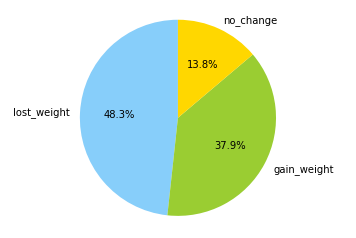

In [20]:
lost_weight = nutri_notes_dropped.Change_Weight[nutri_notes_dropped['Change_Weight']<0].count()
gain_weight = nutri_notes_dropped.Change_Weight[nutri_notes_dropped['Change_Weight']>0].count()
no_change   = nutri_notes_dropped.Change_Weight[nutri_notes_dropped['Change_Weight']==0].count()

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'lost_weight', 'gain_weight', 'no_change'
sizes = [(lost_weight/nutri_notes_df.shape[0]*100),(gain_weight/nutri_notes_df.shape[0]*100),(no_change/nutri_notes_df.shape[0]*100)]
colors = ['lightskyblue','yellowgreen', 'gold']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [21]:
#Next we consider 2 vars one is refrescos (binary) and age (edad)
filename = 'II Datos CMU (BAL).xlsx'
sheetname = 'nutricionvaloracioninicial'
nutri_init_assess = read_data_from_excel(filename,sheetname)

In [22]:
nutri_init_assess.isnull().sum()
nutri_init_assess['Edad'].fillna((nutri_init_assess['Edad'].mean()), inplace=True)

In [23]:
#There are 2 features that can add to the modeling: Refresco and Edad
nutri_init_assess=nutri_init_assess.loc[:, ['IdPaciente', 'Fecha','Refrescos', 'Edad']]
nutri_init_assess.info() 

nutri_init_assess['Fecha'] = pd.to_datetime(nutri_init_assess['Fecha'], errors = 'coerce')
nutri_init_assess['year'], nutri_init_assess['month'] = nutri_init_assess['Fecha'].dt.year, nutri_init_assess['Fecha'].dt.month
nutri_init_assess.sort_values(['IdPaciente','Fecha']).head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12780 entries, 0 to 12779
Data columns (total 4 columns):
IdPaciente    12780 non-null int64
Fecha         12780 non-null object
Refrescos     12770 non-null float64
Edad          12780 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 399.5+ KB


,IdPaciente,Fecha,Refrescos,Edad,year,month
1009,0,2013-09-03,0.0,43.0,2013.0,9.0
0,1,2012-11-01,1.0,86.0,2012.0,11.0
1,2,2011-11-30,1.0,41.0,2011.0,11.0
2,3,2011-12-12,1.0,69.0,2011.0,12.0
2366,3,2014-09-08,0.0,71.0,2014.0,9.0
3,4,2011-12-15,1.0,36.0,2011.0,12.0
4,5,2011-12-15,1.0,54.0,2011.0,12.0
1790,5,2014-05-09,0.0,55.0,2014.0,5.0
5,6,2011-12-16,1.0,57.0,2011.0,12.0
1938,6,2014-06-16,1.0,57.0,2014.0,6.0


In [24]:
#Bring all features here and keep the latest available features per patient
features1= nutri_assess_cal[nutri_assess_cal.groupby('IdPaciente').Fecha.transform('max') == nutri_assess_cal['Fecha']]
features1.sort_values('IdPaciente').head()

features2= nutri_assess_BMI[nutri_assess_BMI.groupby('IdPaciente').Fecha.transform('max') == nutri_assess_BMI['Fecha']]
features2.sort_values('IdPaciente').head()

features3=number_nutri_assess
features3.head()

features4=nutri_notes_changew[nutri_notes_changew.groupby('IdPaciente').DietaPaciente.transform('max')== nutri_notes_changew['DietaPaciente']]
features4.sort_values('IdPaciente').head()   

features5_6= nutri_init_assess[nutri_init_assess.groupby('IdPaciente').Fecha.transform('max') == nutri_init_assess['Fecha']]
features5_6.sort_values('IdPaciente').head()


,IdPaciente,Fecha,Refrescos,Edad,year,month
1009,0,2013-09-03,0.0,43.0,2013.0,9.0
0,1,2012-11-01,1.0,86.0,2012.0,11.0
1,2,2011-11-30,1.0,41.0,2011.0,11.0
2366,3,2014-09-08,0.0,71.0,2014.0,9.0
3,4,2011-12-15,1.0,36.0,2011.0,12.0


In [25]:
features5_6.head()

,IdPaciente,Fecha,Refrescos,Edad,year,month
0,1,2012-11-01,1.0,86.0,2012.0,11.0
1,2,2011-11-30,1.0,41.0,2011.0,11.0
3,4,2011-12-15,1.0,36.0,2011.0,12.0
6,7,2012-01-06,1.0,54.0,2012.0,1.0
7,8,2012-11-19,1.0,35.0,2012.0,11.0


In [26]:
features_all = pd.merge(features1[['IdPaciente','Calorias']], features2[['IdPaciente', 'IMC']], how='outer', on=['IdPaciente'])

In [27]:
#Merge all them here: 
features_all = pd.merge(features1[['IdPaciente','Calorias']], features2[['IdPaciente', 'IMC']], how='outer', on=['IdPaciente'])

features_all = pd.merge(features_all, features3[['num_nutri_assess']], how='outer', on=['IdPaciente'])

features_all = pd.merge(features_all, features4[['IdPaciente','Change_Weight']], how='outer', on=['IdPaciente'])

features_all = pd.merge(features_all, features5_6[['IdPaciente','Edad', 'Refrescos']], how='outer', on=['IdPaciente'])


features_all.sort_values('IdPaciente').head(10)


,IdPaciente,Calorias,IMC,num_nutri_assess,Change_Weight,Edad,Refrescos
402,0,1400.0,NaN,NaN,NaN,43.0,0.0
209,1,1400.0,24.382,3.0,NaN,86.0,1.0
39,2,2000.0,33.515,2.0,NaN,41.0,1.0
1438,3,1500.0,28.380,2.0,NaN,71.0,0.0
40,4,2100.0,39.730,3.0,NaN,36.0,1.0
41,5,1800.0,24.850,15.0,3.2,55.0,0.0
42,5,1800.0,24.850,15.0,3.2,55.0,0.0
633,6,1700.0,25.210,33.0,0.0,57.0,1.0
43,7,1500.0,27.680,7.0,NaN,54.0,1.0
46,8,1600.0,35.782,6.0,NaN,35.0,1.0


In [28]:
#Fill in NaN values with zero: 
features_all.fillna(0, inplace=True)
#features_all.info()

In [29]:
features_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12774 entries, 0 to 12773
Data columns (total 7 columns):
IdPaciente          12774 non-null int64
Calorias            12774 non-null float64
IMC                 12774 non-null float64
num_nutri_assess    12774 non-null float64
Change_Weight       12774 non-null float64
Edad                12774 non-null float64
Refrescos           12774 non-null float64
dtypes: float64(6), int64(1)
memory usage: 798.4 KB


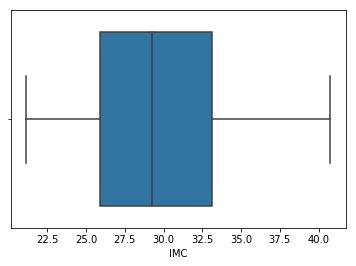

In [30]:
#Outliers in BMI is replaced by the upper and lower values of the dataset (instead of dropping)
upper_lim = features_all['IMC'].quantile(.95)
lower_lim = features_all['IMC'].quantile(.05)

features_all.loc[(features_all['IMC'] > upper_lim)] = upper_lim
features_all.loc[(features_all['IMC'] < lower_lim)] = lower_lim


#features_all = features_all[(features_all['IMC'] < upper_lim) & (features_all['IMC'] > lower_lim)]

sns.boxplot(features_all['IMC'])


In [31]:
#Number of rows with zero values by feature: 361 patients with zero values for Calories, 50 patients with 0 age. 
#Kept these patients; could look for their data from other dataset or drop later! 
(features_all == 0).astype(int).sum(axis=0)


IdPaciente             0
Calorias             361
IMC                    0
num_nutri_assess       0
Change_Weight       6138
Edad                  50
Refrescos           2338
dtype: int64

In [32]:
features_all.loc[features_all['Edad'] ==0].tail(10)  #Edad=0; Calorias=0; for few patients overlap.

,IdPaciente,Calorias,IMC,num_nutri_assess,Change_Weight,Edad,Refrescos
11771,13749.0,1800.0,27.770,2.0,-0.1,0.0,0.0
12514,179.0,0.0,27.145,1.0,0.0,0.0,1.0
12519,150.0,0.0,31.474,1.0,0.0,0.0,1.0
12538,67.0,0.0,33.600,1.0,0.0,0.0,1.0
12590,3986.0,0.0,32.840,1.0,0.0,0.0,1.0
12610,4289.0,0.0,34.550,2.0,0.0,0.0,0.0
12641,7135.0,0.0,21.600,10.0,-0.4,0.0,0.0
12646,11526.0,0.0,23.960,1.0,1.7,0.0,0.0
12674,13511.0,0.0,35.990,1.0,0.0,0.0,0.0
12711,11665.0,0.0,37.230,3.0,-12.2,0.0,0.0


In [33]:
#Inspect: cancellation membership info
filename = 'IV Datos CMU (BAL).xlsx'
dataframe =  pd.ExcelFile('s3://{}/{}'.format(bucketname, filename))#, encoding = 'ISO-8859-1')

dataframe.sheet_names

['cm_tickets',
 'evoluciones',
 'estatusrazonesnocompro_n2',
 'estatusrazonesnocompro']

In [34]:
filename = 'IV Datos CMU (BAL).xlsx'
sheetname = 'evoluciones'
cm_tickets = read_data_from_excel(filename,sheetname)

In [37]:
cm_tickets.info()
(cm_tickets == 1).astype(int).sum(axis=0) #About 39,998 records for cancelled membership
cm_tickets.sort_values(['IdPaciente', 'Fecha']).head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35142 entries, 0 to 35141
Data columns (total 31 columns):
IdEvolucion                     35142 non-null int64
IdPaciente                      35142 non-null int64
Fecha                           35142 non-null datetime64[ns]
Hora                            35142 non-null object
ReporteEventosComplicaciones    4332 non-null object
NotaEvolucion                   34546 non-null object
Pronostico                      28689 non-null object
usuario                         35142 non-null object
Temperatura                     35142 non-null float64
FC                              35142 non-null int64
FR                              35142 non-null int64
Peso                            35142 non-null float64
Talla                           35142 non-null float64
CC                              35142 non-null float64
HADiastolica                    35142 non-null int64
HASistolica                     35142 non-null int64
FechaReceta           

,IdEvolucion,IdPaciente,Fecha,Hora,ReporteEventosComplicaciones,NotaEvolucion,Pronostico,usuario,Temperatura,FC,...,TipoHipoglucemia,AP,EC,IA,AR,IC,AC,DM,AnioDM,TipoDM
1286,1287,0,2013-07-31,13:01:36,NaN,NaN,NaN,8c4205ec33d8f6caeaaaa0c10a14138c,0.0,0,...,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN
549,550,1,2013-03-19,18:31:08,M.C. Vision Borrosa Cronica\nEF: ECG 15 \nORL...,"Don Felix, paciente masculino con antecedente ...","BUENO PARA LA FUNCIÓN Y PARA LA VIDA, LIGADO A...",27326ef339d2c7e5561abd6e1b2f5771,36.5,77,...,NaN,0,0,0,0,0,0.0,1.0,1992.0,TIPO 2
550,551,1,2013-03-19,18:31:58,NaN,El día de hoy acude a consulta de control d...,"BUENO PARA LA FUNCIÓN Y PARA LA VIDA, LIGADO A...",27326ef339d2c7e5561abd6e1b2f5771,36.5,77,...,NaN,0,0,0,0,0,0.0,1.0,1992.0,TIPO 2
551,552,1,2013-03-19,18:32:53,NaN,S: Legaña matutina y periodos de somnolencia\n...,"BUENO PARA LA FUNCIÓN Y PARA LA VIDA, LIGADO A...",27326ef339d2c7e5561abd6e1b2f5771,36.5,77,...,NaN,0,0,0,0,0,0.0,1.0,1992.0,TIPO 2
552,553,1,2013-08-28,14:25:18,NaN,RESUMEN CLINICO Se trata de paciente mascul...,"BUENO PARA LA FUNCIÓN Y PARA LA VIDA, LIGADO A...",27326ef339d2c7e5561abd6e1b2f5771,36.5,77,...,NaN,0,0,0,0,0,0.0,1.0,1992.0,TIPO 2
4763,4764,3,2014-09-08,12:03:54,NaN,se trata de paciente femenino de 70 año...,"BUENO PARA LA FUNCIÓN Y PARA LA VIDA, LIGADO A...",b13402b8c58ee591925c08f6e0bb7668,0.0,0,...,NaN,0,0,0,0,0,0.0,1.0,1986.0,TIPO 2
4806,4807,3,2014-09-11,15:42:10,se reciben los laboratorio de quimica sang...,se trata de paciente femenino de 70 años...,"BUENO PARA LA FUNCIÓN Y PARA LA VIDA, LIGADO A...",b13402b8c58ee591925c08f6e0bb7668,0.0,0,...,NaN,0,0,0,0,0,0.0,1.0,1986.0,TIPO 2
426,427,4,2013-03-15,11:53:08,NaN,Acude a control. Se refiere asintomático. Meta...,NaN,39564f3f8482346e4764d24bb0a60260,0.0,0,...,NaN,0,0,0,0,0,0.0,1.0,2011.0,TIPO 2
427,428,4,2013-03-15,11:53:23,NaN,Se trata de paciente masculino de 36 años se...,NaN,39564f3f8482346e4764d24bb0a60260,0.0,0,...,NaN,0,0,0,0,0,0.0,1.0,2011.0,TIPO 2
17,18,5,2013-03-04,16:22:07,NaN,NOTA INICIAL Se trata de paciente masculino d...,"BUENO PARA LA FUNCIÓN Y PARA LA VIDA, LIGADO A...",39564f3f8482346e4764d24bb0a60260,0.0,0,...,NaN,0,0,0,0,0,0.0,1.0,2005.0,TIPO 2


In [41]:
bucketname = "group4bucketapr20"
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(bucketname)
for my_bucket_object in my_bucket.objects.all():
    print(my_bucket_object)

#Read the outcome csv file
filename = 'outcome_var2.csv'
outcome_df = read_data_from_csv(filename)
outcome_df = outcome_df.loc[:, ~outcome_df.columns.str.contains('^Unnamed')]
outcome_df.head()

#Consolidated
filename = 'consolidated_numerical2.csv'
outcome_df2 = read_data_from_csv(filename)
outcome_df2 = outcome_df2.loc[:, ~outcome_df2.columns.str.contains('^Unnamed')]
outcome_df2.head()

,Unnamed: 0,IdPaciente,M1,M2,M3,M4,M5,M6,M7,M8,...,M39,M40,M41,M42,M43,M44,M45,M46,M47,M48
0,0,0.0,2,2,2,2,2,2,2,2,...,2,2,2,2,2,1,1,1,1,1
1,1,1.0,3,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2,2.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,3,3.0,2,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,4,4.0,3,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


It appears there is more variation in engagement levelt during the first 6 months. At 6th month, 66% of patients
have low engagement level (=2), at month 12, this reaches 85.6%, by the 18th month, it is about 95.2%
anything beyond 12th month, the target variable appears highly imbalanced. 

In [94]:
#Outcome engagement levels by levels of engagement: 
outcome_df.head()
outcome_df.nunique()
list=['M1', 'M2', 'M3', 'M4', 'M5', 'M6','M12', 'M18', 'M24', 'M30', 'M36', 'M48']
no_eng_list = [0]*len(list)
i = 0
for item in list:
    df = outcome_df[item].value_counts().reset_index()
    df.columns = [item, 'count']
    #count=df.loc[df[item] == 2]
    df1 = df.loc[df[item] == 2].copy()
    if i==0:
        i += 1
        continue
    else:
        no_eng_list[i] = df1['count'].loc[0] / 13907 * 100
        i += 1
    df1['count'].loc[0]
    #print(item, count)
    
print(no_eng_list)

[0, 19.73107068382829, 39.45495074422952, 33.127202128424535, 54.440209966204065, 66.06744804774574, 85.92794995326095, 95.2326166678651, 97.57675990508376, 98.71287840655785, 99.22341266987847, 99.79866254404257]


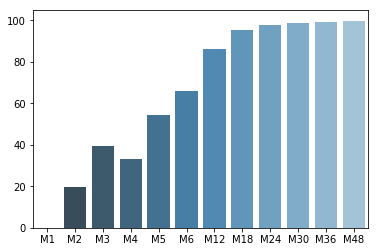

In [96]:
count_no_eng = pd.DataFrame(columns = list)
count_no_eng[len(count_no_eng)] = no_eng_list

ax = sns.barplot(x=list , y=no_eng_list, 
                 palette="Blues_d")

In [80]:
#Merge features with outcome var df: Take the first 6 months data; since we have only 36 months of patient engagement
#data, the majority of the patient engagement is recorded in the first 12 months.
outcome_df_6=outcome_df.loc[:, 'IdPaciente':'M6']
outcome_df_6.info()

data = pd.merge(outcome_df_6, features_all, how='inner', on=['IdPaciente'])

#Consolidated file
outcome_df2_6=outcome_df2.loc[:, 'IdPaciente':'M6']
outcome_df2_6.info()
data2 = pd.merge(outcome_df2_6, features_all, how='inner', on=['IdPaciente'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13907 entries, 0 to 13906
Data columns (total 7 columns):
IdPaciente    13907 non-null float64
M1            13907 non-null float64
M2            13907 non-null float64
M3            13907 non-null float64
M4            13907 non-null float64
M5            13907 non-null float64
M6            13907 non-null float64
dtypes: float64(7)
memory usage: 760.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13907 entries, 0 to 13906
Data columns (total 7 columns):
IdPaciente    13907 non-null float64
M1            13907 non-null int64
M2            13907 non-null int64
M3            13907 non-null int64
M4            13907 non-null int64
M5            13907 non-null int64
M6            13907 non-null int64
dtypes: float64(1), int64(6)
memory usage: 760.6 KB


In [83]:
data.info()
data.describe()
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11335 entries, 0 to 11334
Data columns (total 13 columns):
IdPaciente          11335 non-null float64
M1                  11335 non-null float64
M2                  11335 non-null float64
M3                  11335 non-null float64
M4                  11335 non-null float64
M5                  11335 non-null float64
M6                  11335 non-null float64
Calorias            11335 non-null float64
IMC                 11335 non-null float64
num_nutri_assess    11335 non-null float64
Change_Weight       11335 non-null float64
Edad                11335 non-null float64
Refrescos           11335 non-null float64
dtypes: float64(13)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11335 entries, 0 to 11334
Data columns (total 13 columns):
IdPaciente          11335 non-null float64
M1                  11335 non-null int64
M2                  11335 non-null int64
M3                  11335 non-null int64
M4              

#### Building our feature Table

In [84]:
#Modeling: splitting into labels and features
labels=data.loc[:,['M6']]
features=data[data.columns[~data.columns.isin(['IdPaciente','M6'])]]
features.head()

labels2=data2.loc[:,['M6']]
features2=data2[data2.columns[~data2.columns.isin(['IdPaciente','M6'])]]
features2.head()

,M1,M2,M3,M4,M5,Calorias,IMC,num_nutri_assess,Change_Weight,Edad,Refrescos
0,3,1,1,2,1,1400.0,24.382,3.0,0.0,86.0,1.0
1,1,1,1,1,1,2000.0,33.515,2.0,0.0,41.0,1.0
2,2,1,1,1,1,1500.0,28.380,2.0,0.0,71.0,0.0
3,3,1,1,1,1,2100.0,39.730,3.0,0.0,36.0,1.0
4,2,1,1,2,1,1800.0,24.850,15.0,3.2,55.0,0.0


In [85]:
#Making sure the target variable is a multiclass categorical var
from sklearn import preprocessing
from sklearn import utils
y = data.M6 # define the target variable (dependent variable) as y
y=y.astype(int)  #need to convert to INT from float
y.head(10)
y.dtype

y2 = data2.M6 # define the target variable (dependent variable) as y
y2=y2.astype(int)  #need to convert to INT from float
y2.head(10)
y2.dtype

print(utils.multiclass.type_of_target(y2))

multiclass


In [86]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#Overall
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#Consolidated
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, y2, test_size=0.2)
print(X_train2.shape, y_train2.shape)
print(X_test2.shape, y_test2.shape)

(9068, 11) (9068,)
(2267, 11) (2267,)
(9068, 11) (9068,)
(2267, 11) (2267,)
(9068, 11) (9068,)
(2267, 11) (2267,)


#### Classification :

1. Logistic Regression for all engagement level
2. Logistic Regression for consolidated engagement levels (High, Medium, Low)
3. Random Forest for all engagement level
4. Random Forest for consolidated engagement levels (High, Medium, Low)

In [87]:
#Logistic Regression: Classification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import multilabel_confusion_matrix  #Not importing
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
logreg_pred_class1 = logreg.predict(X_test)

#Consolidated:
logreg2 = LogisticRegression()
logreg2.fit(X_train2, y_train2)
logreg2_pred_class2 = logreg2.predict(X_test2)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

In [108]:
#print(pd.DataFrame(logreg_pred_class1))
from sklearn.metrics import plot_confusion_matrix

In [109]:
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

print(confusion_matrix(y_test, logreg_pred_class1))
print(classification_report(y_test, logreg_pred_class1))

#Consolidated
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg2.score(X_test2, y_test2)))

print(confusion_matrix(y_test2, logreg2_pred_class2))
print(classification_report(y_test2, logreg2_pred_class2))

Accuracy of Logistic regression classifier on test set: 0.66
[[1303    7    0    0    0    0   48    0    4    0    0]
 [ 145    3    0    0    0    0   48    0    2    0    0]
 [   8    0    0    0    0    0    1    0    0    0    0]
 [  25    1    0    0    0    0   18    0    0    0    0]
 [  12    1    0    0    0    0    4    0    0    0    0]
 [  52    1    0    0    0    0   55    0    0    0    0]
 [  97    3    0    0    0    0  184    0    2    0    0]
 [  24    0    0    0    0    0   35    0    1    0    0]
 [  33    0    0    0    0    0   86    0    1    0    0]
 [   3    0    0    0    0    0    2    0    0    0    0]
 [  43    0    0    0    0    0   14    0    1    0    0]]
              precision    recall  f1-score   support

           2       0.75      0.96      0.84      1362
           3       0.19      0.02      0.03       198
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00        44
           6       0.00      

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

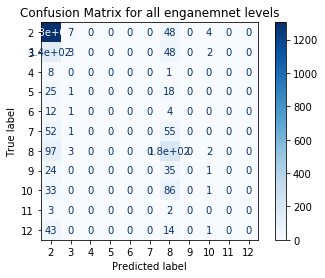

<Figure size 2880x2880 with 0 Axes>

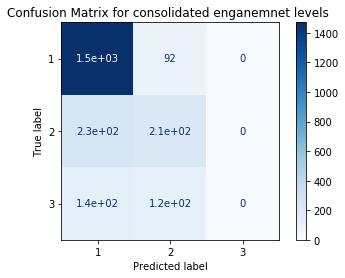

<Figure size 2880x2880 with 0 Axes>

In [128]:
# Plot non-normalized confusion matrix

class_names = [2,3,4,5,6,7,8,9,10,11,12]
disp = plot_confusion_matrix(logreg,  X_test, y_test,
                                display_labels=class_names,
                                cmap=plt.cm.Blues,)
disp.ax_.set_title('Confusion Matrix for all enganemnet levels')


plt.figure(figsize=(40, 40))
    

plt.show()


# Plot non-normalized confusion matrix

class_names = [1,2,3]
disp = plot_confusion_matrix(logreg2, X_test2, y_test2,
                                display_labels=class_names,
                                cmap=plt.cm.Blues,)
disp.ax_.set_title('Confusion Matrix for consolidated enganemnet levels ')


plt.figure(figsize=(40, 40))
    

plt.show()

In [90]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500, max_depth=4, random_state=0)
rf2 = RandomForestClassifier(n_estimators=500, max_depth=4, random_state=0)

#All levels
rf.fit(X_train, y_train)
rf_pred_class1 = rf.predict(X_test)

#Consolidated
rf2.fit(X_train2, y_train2)
rf2_pred_class2 = rf2.predict(X_test2)

In [91]:
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

print(confusion_matrix(y_test, rf_pred_class1))
print(classification_report(y_test, rf_pred_class1))

#Consolidated
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(rf2.score(X_test2, y_test2)))

print(confusion_matrix(y_test2, rf2_pred_class2))
print(classification_report(y_test2, rf2_pred_class2))

Accuracy of RF classifier on test set: 0.69
[[1322    0    0    0    0    0   37    0    3    0    0]
 [ 136    0    0    0    0    0   61    0    1    0    0]
 [   5    0    0    0    0    0    4    0    0    0    0]
 [  17    0    0    0    0    0   27    0    0    0    0]
 [  10    0    0    0    0    0    7    0    0    0    0]
 [  55    0    0    0    0    0   44    0    9    0    0]
 [  74    0    0    0    0    0  205    0    7    0    0]
 [  24    0    0    0    0    0   26    0   10    0    0]
 [  40    0    0    0    0    0   50    0   30    0    0]
 [   4    0    0    0    0    0    0    0    1    0    0]
 [  43    0    0    0    0    0   13    0    2    0    0]]
              precision    recall  f1-score   support

           2       0.76      0.97      0.86      1362
           3       0.00      0.00      0.00       198
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00        44
           6       0.00      0.00      0.00   

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

As we can see from the above charts the accuracy scores are as follows

1. Logistic Regression for all engagement level - 68%
2. Logistic Regression for consolidated engagement levels (High, Medium, Low) - 74%
3. Random Forest for all engagement level - 69%
4. Random Forest for consolidated engagement levels (High, Medium, Low) - 79%

<b>Inferences:</b>

As we can see from the above models that due to a lot of records where patient have no engagement (engagement level = 2) the same seems to be slightly skewed towards the same as we can see that though the accuracy is high we can see that there are a other engagement levels that have been completely misclassified due to the low dataset. 

Though consolidating the engagement levels helped increase the accuracy of the model as it solved the previous problem of insufficient data to a certain extent however high engagement examples are less and hence we can still see the skewness in the model predictions

#### Let us try to understand and identify important features

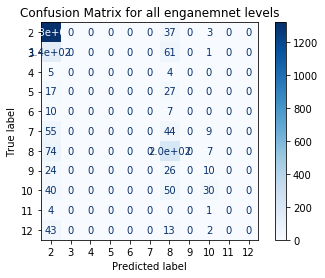

<Figure size 2880x2880 with 0 Axes>

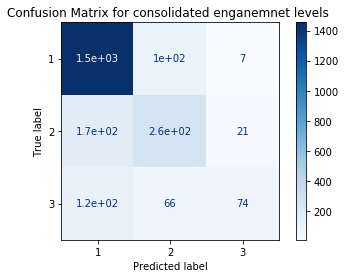

<Figure size 2880x2880 with 0 Axes>

In [129]:
# Plot non-normalized confusion matrix

class_names = [2,3,4,5,6,7,8,9,10,11,12]
disp = plot_confusion_matrix(rf,  X_test, y_test,
                                display_labels=class_names,
                                cmap=plt.cm.Blues,)
disp.ax_.set_title('Confusion Matrix for all enganemnet levels')


plt.figure(figsize=(40, 40))
    

plt.show()


# Plot non-normalized confusion matrix

class_names = [1,2,3]
disp = plot_confusion_matrix(rf2, X_test2, y_test2,
                                display_labels=class_names,
                                cmap=plt.cm.Blues,)
disp.ax_.set_title('Confusion Matrix for consolidated enganemnet levels ')


plt.figure(figsize=(40, 40))
    

plt.show()

                  importance
M5                  0.419402
num_nutri_assess    0.287335
M4                  0.156881
M3                  0.093298
M2                  0.020840
Change_Weight       0.010725
Edad                0.004445
M1                  0.003382
IMC                 0.001900
Calorias            0.001681
Refrescos           0.000109


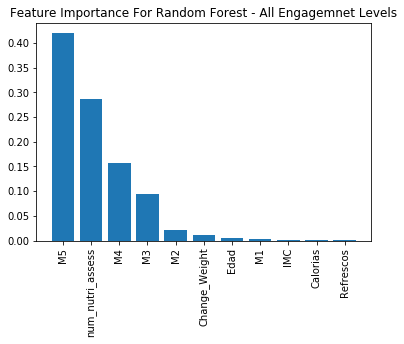

                  importance
num_nutri_assess    0.349989
M5                  0.316017
M4                  0.162437
M3                  0.119553
M2                  0.027289
Change_Weight       0.013066
Edad                0.005022
Calorias            0.002737
IMC                 0.002204
M1                  0.001502
Refrescos           0.000185


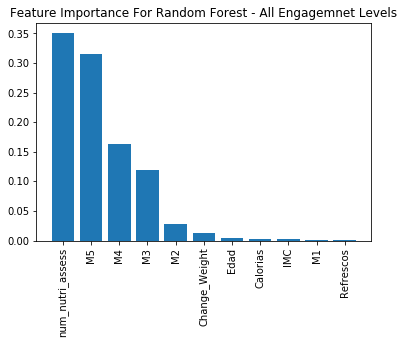

In [133]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances)

# Calculate feature importances
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance For Random Forest - All Engagemnet Levels")

# Add bars
plt.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()

#Consolidated:
feature_importances2 = pd.DataFrame(rf2.feature_importances_,
                                   index = X_train2.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances2)

# Calculate feature importances
importances = rf2.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train2.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance For Random Forest - All Engagemnet Levels")

# Add bars
plt.bar(range(X_train2.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train2.shape[1]), names, rotation=90)

# Show plot
plt.show()


As we can see from the above diagrams the previous months engagement levels act as a good predictor for that of th enext month engagement levels.

Also we can see that the number of nutrition assessments a person had also turns out to be a good predictor as it directly correlates to patient engagament with the clinic



#### Time Series Forecasting for this dataset

In [137]:
pred_df = outcome_df.loc[:,'M1':'M48'].copy()
pred_df.head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,...,M39,M40,M41,M42,M43,M44,M45,M46,M47,M48
0,6.75,6.75,6.2,6.75,5.0,6.25,5.67,5.25,5.67,6.75,...,6.2,5.0,6.2,5.25,5.25,2.0,2.0,2.0,2.0,2.0
1,12.00,2.00,2.0,7.00,2.0,2.00,2.00,2.00,2.00,2.00,...,2.0,2.0,2.0,2.00,2.00,2.0,2.0,2.0,2.0,2.0
2,3.00,2.00,2.0,2.00,2.0,2.00,2.00,2.00,2.00,2.00,...,2.0,2.0,2.0,2.00,2.00,2.0,2.0,2.0,2.0,2.0
3,6.50,4.00,2.0,3.00,2.0,2.00,2.00,2.00,2.00,2.00,...,2.0,2.0,2.0,2.00,2.00,2.0,2.0,2.0,2.0,2.0
4,10.00,2.00,2.0,2.00,2.0,2.00,2.00,2.00,2.00,2.00,...,2.0,2.0,2.0,2.00,2.00,2.0,2.0,2.0,2.0,2.0


In order to do forcasting across the time period for teh overall population we took an average of their engagement level across each month

In [275]:
avg_df = pred_df.mean(axis = 0)
avg_df.columns=['Value']
avg_df

M1     9.226017
M2     6.290148
M3     5.182606
M4     5.329523
M5     4.309624
M6     3.788043
M7     4.087929
M8     3.366769
M9     3.005990
M10    3.284606
M11    2.898214
M12    2.702864
M13    2.872057
M14    2.499434
M15    2.380713
M16    2.379291
M17    2.310984
M18    2.260475
M19    2.279865
M20    2.217985
M21    2.177076
M22    2.206357
M23    2.155258
M24    2.123416
M25    2.141519
M26    2.104411
M27    2.091799
M28    2.087177
M29    2.078319
M30    2.071990
M31    2.076293
M32    2.066878
M33    2.051888
M34    2.054537
M35    2.045762
M36    2.042926
M37    2.044296
M38    2.034319
M39    2.028474
M40    2.029936
M41    2.025540
M42    2.021274
M43    2.019590
M44    2.019722
M45    2.017316
M46    2.016098
M47    2.011379
M48    2.011166
dtype: float64

In [276]:
month_list = [0] * 48
for i in range(48):
    month_list[i] = "M" + str(i+1)

In [277]:
avg_df = avg_df.reset_index()

In [278]:
avg_df.columns = ['Month', 'Avg_Eng']

In [279]:
avg_df.head()

,Month,Avg_Eng
0,M1,9.226017
1,M2,6.290148
2,M3,5.182606
3,M4,5.329523
4,M5,4.309624


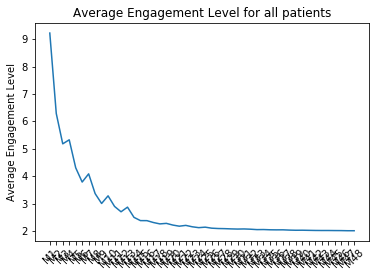

<Figure size 2880x2880 with 0 Axes>

In [280]:
# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(avg_df.Month, avg_df.Avg_Eng)
plt.title('Average Engagement Level for all patients')
plt.xticks(rotation=45)
plt.ylabel('Average Engagement Level')
plt.figure(figsize = (40,40))
    
plt.show()

As we can see above that the engagement is reducing over a time period but at the same time there are some peaks that can be seen every 2-3 months in the dataset.

Let us use MA as we are to predict the outcome for M+1 depending on M and M-1

In order to achieve this for now we only considered the previous months engagement levels as predictors as from the classification exercise it was eveident that they were good predictors

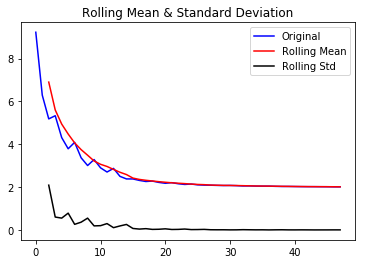

In [281]:
 #Determing rolling statistics
rolmean = avg_df['Avg_Eng'].rolling(window=3).mean()
rolstd = avg_df['Avg_Eng'].rolling(window=3).std()



#Plot rolling statistics:
orig = plt.plot(avg_df['Avg_Eng'], color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Taking the log transform of the data for simplicity. In order to penalize the higher values more than the smaller values to be able to transform the data

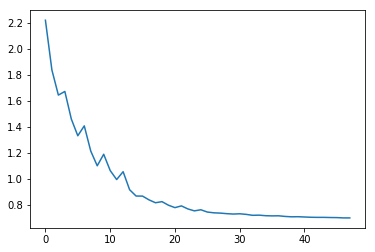

In [282]:
plt.plot(np.log(avg_df['Avg_Eng']))
ts_log = avg_df.copy()
ts_log['Avg_Eng'] = np.log(avg_df['Avg_Eng'])

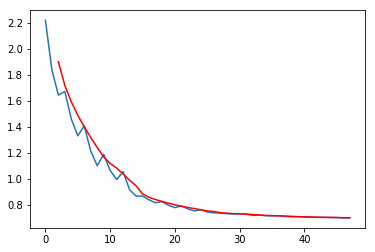

In [283]:
moving_avg = ts_log['Avg_Eng'].rolling(window=3).mean()
plt.plot(ts_log['Avg_Eng'])
plt.plot(moving_avg, color='red')

#### Eliminating Sesonality and Trend in the data

1. Differencing – taking the differece with a particular time lag
2. Decomposition – modeling both trend and seasonality and removing them from the model.


In order to test the stationarity of the data we will be using the Dickie-Fuller Test

In [284]:
ts_log_moving_avg_diff = ts_log['Avg_Eng'] - moving_avg
ts_log_moving_avg_diff.head(12)

0          NaN
1          NaN
2    -0.256799
3    -0.045923
4    -0.132289
5    -0.156804
6     0.007792
7    -0.103994
8    -0.140259
9     0.021311
10   -0.053888
11   -0.088239
Name: Avg_Eng, dtype: float64

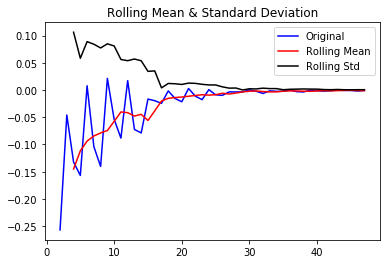

Results of Dickey-Fuller Test:
Test Statistic                 -4.580151
p-value                         0.000140
#Lags Used                     10.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


In [285]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

In [286]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=3).mean()
    rolstd =  timeseries.rolling(window=3).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

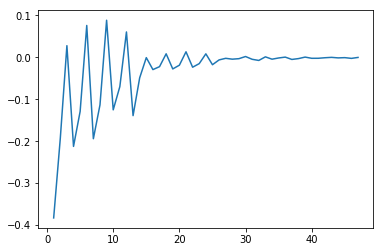

In [287]:
ts_log_diff = ts_log['Avg_Eng'] - ts_log['Avg_Eng'].shift()
plt.plot(ts_log_diff)

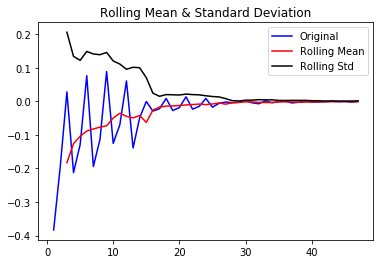

Results of Dickey-Fuller Test:
Test Statistic                 -5.341640
p-value                         0.000004
#Lags Used                      6.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


In [288]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [289]:
ts_log['Avg_Eng'].to_numpy()

array([2.22202744, 1.83898462, 1.645308  , 1.67326165, 1.46085065,
       1.33184945, 1.40803851, 1.21395361, 1.10060689, 1.1892468 ,
       1.06409463, 0.99431196, 1.05502858, 0.91606435, 0.86739985,
       0.86680255, 0.83767327, 0.8155751 , 0.82411615, 0.79659921,
       0.77798283, 0.79134252, 0.76791034, 0.75302624, 0.76151557,
       0.74403583, 0.73802451, 0.73581242, 0.73155931, 0.72850967,
       0.73058386, 0.72603917, 0.71876012, 0.72005031, 0.71577026,
       0.71438303, 0.71505367, 0.71016132, 0.70728386, 0.70800427,
       0.70583652, 0.70372809, 0.70289459, 0.7029601 , 0.70176814,
       0.70116379, 0.69882064, 0.69871445])

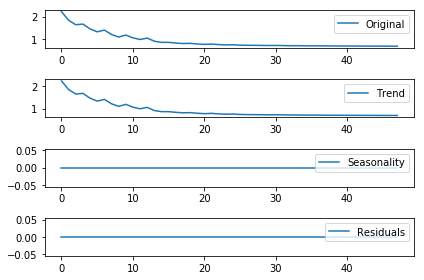

In [290]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log['Avg_Eng'],freq=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log['Avg_Eng'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### Using the ARIMA Model on the preprocessed data
#### with a focus on MA (Moving Average) Model

In [291]:
from statsmodels.tsa.arima_model import ARIMA

RSS: 0.2722


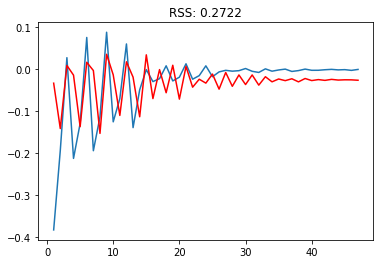

In [306]:
model = ARIMA(ts_log['Avg_Eng'], order=(0, 1, 2))  
results_MA = model.fit(disp=0)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
print('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

In [302]:
df = ts_log.copy()
df['Fitted_values'] = results_MA.fittedvalues
df.head()

,Month,Avg_Eng,Fitted_values
0,M1,2.222027,NaN
1,M2,1.838985,-0.032910
2,M3,1.645308,-0.141165
3,M4,1.673262,0.009342
4,M5,1.460851,-0.013705


#### Plotting the residuals & Density Plot of Residuals

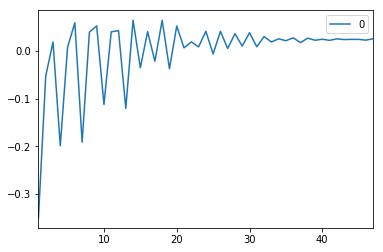

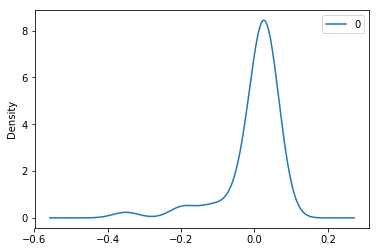

               0
count  47.000000
mean   -0.000986
std     0.076914
min    -0.350133
25%     0.007017
50%     0.022630
75%     0.037171
max     0.064395


In [305]:
#plotting residuals

residuals = pd.DataFrame(results_MA.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

<b><u>References:</u></b>

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/